<a href="https://colab.research.google.com/github/legardajuanpablo-byte/sp_1_JuanPablo_Legarda.ipynb/blob/main/sesiones_practicas/sp_1_JuanPablo_Legarda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Inastalacion Librerías
!pip -q install rasterio geopandas shapely matplotlib
!pip -q install rasterio pandas

# Librerías
import numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import rasterio, os, time
import rasterio
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds
from pyproj import Geod
import rasterio, pandas as pd
# Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
#  DataScience_Sentinel1ProjectDegree
BASE = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree')
assert BASE.exists(), f"No existe: {BASE}. Revisa el nombre de la carpeta en tu Drive."

# Buscar bandas (SNAP .img o GeoTIFF .tif) dentro de BASE
def find_bands(base: Path):
    imgs = list(base.rglob('*.img')) + list(base.rglob('*.tif'))
    vv = [p for p in imgs if 'sigma0_vv' in p.name.lower() or '_vv' in p.name.lower()]
    vh = [p for p in imgs if 'sigma0_vh' in p.name.lower() or '_vh' in p.name.lower()]
    return (vv[0] if vv else None), (vh[0] if vh else None)

IMG_VV, IMG_VH = find_bands(BASE)
print("Sigma0_VV:", IMG_VV)
print("Sigma0_VH:", IMG_VH)
assert IMG_VV is not None, "No encontré Sigma0_VV (ni .img ni .tif) dentro de BASE."



Sigma0_VV: /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/S1C_IW_GRDH_1SDV_20250726T230637_20250726T230704_003398_006D5D_262B_Orb_Cal_Spk_TC.data/Sigma0_VV.img
Sigma0_VH: /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/S1C_IW_GRDH_1SDV_20250726T230637_20250726T230704_003398_006D5D_262B_Orb_Cal_Spk_TC.data/Sigma0_VH.img


In [4]:

def crop_to_bbox(in_path, out_path, bbox_wgs84, nodata=np.nan):
    """
    Lee SOLO la ventana que cae dentro del bbox (WGS84) y la guarda en GeoTIFF (float32 dB, LZW).
    bbox_wgs84 = (lon_min, lat_min, lon_max, lat_max)
    """
    with rasterio.open(in_path) as src:
        # Llevar bbox al CRS del raster si no está en EPSG:4326
        if src.crs and src.crs.to_string() != "EPSG:4326":
            bbox_src = transform_bounds("EPSG:4326", src.crs, *bbox_wgs84, densify_pts=21)
        else:
            bbox_src = bbox_wgs84

        win = from_bounds(*bbox_src, transform=src.transform).round_offsets().round_lengths()
        arr = src.read(1, window=win).astype("float32")
        # a dB si venía en lineal (>0)
        if np.nanmin(arr) > 0:
            m = np.isfinite(arr)
            arr[m] = 10*np.log10(arr[m])

        meta = src.meta.copy()
        meta.update({
            "driver": "GTiff",
            "height": int(win.height),
            "width": int(win.width),
            "transform": src.window_transform(win),
            "dtype": "float32",
            "nodata": nodata,
            "compress": "LZW",
            "tiled": True,
            "BIGTIFF": "IF_SAFER",
        })

    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(arr[np.newaxis, ...])
    return out_path


In [5]:


BASE = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree')

def pick_band(base: Path, key: str):
    cands = list(base.rglob(f'*{key}*.img')) + list(base.rglob(f'*{key}*.tif'))
    if not cands: return None
    # productos "Orb_Cal_Spk_TC"
    cands.sort(key=lambda p: ('Orb_Cal_Spk_TC' not in str(p), -p.stat().st_mtime))
    return cands[0]

IMG_VV = pick_band(BASE, 'Sigma0_VV') or pick_band(BASE, '_VV')
IMG_VH = pick_band(BASE, 'Sigma0_VH') or pick_band(BASE, '_VH')

assert IMG_VV is not None, "No se encontró Sigma0_VV"
print("VV:", IMG_VV)
print("VH:", IMG_VH)


VV: /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/S1C_IW_GRDH_1SDV_20250726T230637_20250726T230704_003398_006D5D_262B_Orb_Cal_Spk_TC.data/Sigma0_VV.img
VH: /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/S1C_IW_GRDH_1SDV_20250726T230637_20250726T230704_003398_006D5D_262B_Orb_Cal_Spk_TC.data/Sigma0_VH.img


In [6]:


def crop_to_bbox(in_path, out_path, bbox_wgs84, nodata=np.nan):
    with rasterio.open(in_path) as src:
        bbox_src = transform_bounds("EPSG:4326", src.crs, *bbox_wgs84, densify_pts=21) if src.crs and src.crs.to_string()!="EPSG:4326" else bbox_wgs84
        win = from_bounds(*bbox_src, transform=src.transform).round_offsets().round_lengths()
        arr = src.read(1, window=win).astype("float32")
        if np.nanmin(arr) > 0:  # a dB solo si venía lineal
            m = np.isfinite(arr); arr[m] = 10*np.log10(arr[m])
        meta = src.meta.copy()
        meta.update({"driver":"GTiff","height":int(win.height),"width":int(win.width),
                     "transform":src.window_transform(win),"dtype":"float32",
                     "nodata":nodata,"compress":"LZW","tiled":True,"BIGTIFF":"IF_SAFER"})
    out_path = Path(out_path); out_path.parent.mkdir(parents=True, exist_ok=True)
    with rasterio.open(out_path, "w", **meta) as dst: dst.write(arr[np.newaxis,...])
    return out_path

# BBox compacto CGSM (WGS84)
bbox = (-74.70, 10.60, -74.20, 11.05)

OUT = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs')
vv_clip = crop_to_bbox(IMG_VV, OUT/'Sigma0_VV_CGSM_dB.tif', bbox)
vh_clip = None
if 'IMG_VH' in globals() and IMG_VH is not None:
    vh_clip = crop_to_bbox(IMG_VH, OUT/'Sigma0_VH_CGSM_dB.tif', bbox)

print("VV →", vv_clip)
print("VH →", vh_clip if vh_clip else "no disponible")



VV → /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs/Sigma0_VV_CGSM_dB.tif
VH → /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs/Sigma0_VH_CGSM_dB.tif


## Visualizacion bandas Multiespectrales VV/VH

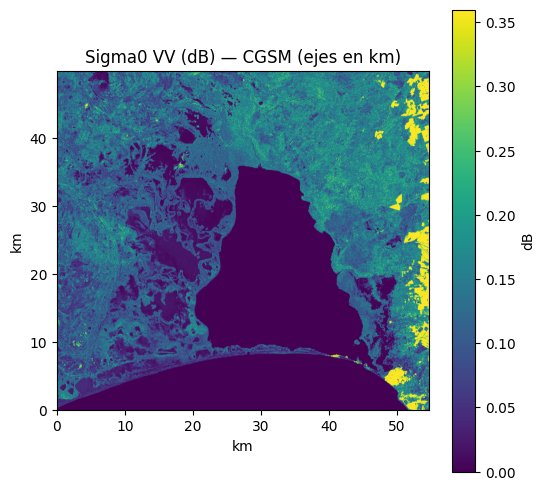

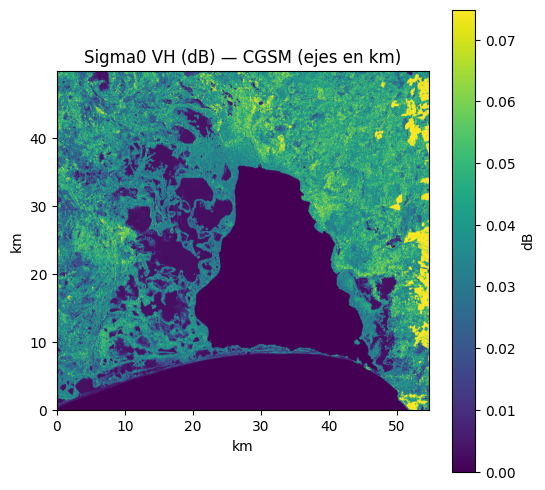

In [8]:
from pyproj import Geod

def extent_km(tif_path):
    with rasterio.open(tif_path) as src:
        left,bottom,right,top = src.bounds
        geod = Geod(ellps="WGS84")
        midlat = (top+bottom)/2; midlon = (left+right)/2
        _,_,width_m  = geod.inv(left,  midlat, right, midlat)   # E–W
        _,_,height_m = geod.inv(midlon,bottom, midlon, top)     # N–S
        return (width_m/1000.0, height_m/1000.0), src.read(1)

# VV
(vv_w_km, vv_h_km), vv_arr = extent_km(vv_clip)

# VH (si existe)
vh_arr, vh_w_km, vh_h_km = None, None, None
if vh_clip:
    (vh_w_km, vh_h_km), vh_arr = extent_km(vh_clip)

# Plot mapas con ejes en km
def show_map(arr, w_km, h_km, title):
    p2, p98 = np.nanpercentile(arr,2), np.nanpercentile(arr,98)
    plt.figure(figsize=(6,6))
    plt.imshow(arr, vmin=p2, vmax=p98, extent=[0, w_km, 0, h_km], origin='lower')
    plt.xlabel("km"); plt.ylabel("km"); plt.title(title)
    cb = plt.colorbar(); cb.set_label("dB"); plt.show()

show_map(vv_arr, vv_w_km, vv_h_km, "Sigma0 VV (dB) — CGSM (ejes en km)")
if vh_arr is not None:
    show_map(vh_arr, vh_w_km, vh_h_km, "Sigma0 VH (dB) — CGSM (ejes en km)")




Los **metadatos** de una imagen SAR —CRS (p. ej., WGS84), `bounds`/`transform` (extensión y georreferenciación), resolución, fecha/hora y órbita/ángulo de incidencia, polarización (VV, VH) y estado de calibración— son los que permiten interpretar físicamente cada píxel y convertirlo en distancias reales. En nuestras bandas VV y VH se aprecia el fenómeno de retroespalamiento: sobre agua predomina la reflexión especular (muy poca energía vuelve al radar) → dB muy negativos, sobre todo en VV; en vegetación/manglar domina la dispersión volumétrica, elevando VH respecto a VV. Leer correctamente estos metadatos (CRS y límites) nos permite mostrar la Ciénaga en kilómetros, comparar bandas en la misma escala y entender que las diferencias de dB se deben a propiedades físicas del medio (rugosidad y constante dieléctrica) y a la geometría de adquisición, no a errores de visualización.


## Descripción de la base de datos

In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from pathlib import Path
OUT = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs')
print("OUT:", OUT, "| existe:", OUT.exists())
print("Contenido de OUT:")
print("\n".join(p.name for p in OUT.glob("*")) or "(vacío)")



Mounted at /content/drive
OUT: /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs | existe: True
Contenido de OUT:
scatter_vv_vh.png
hist_vh.png
hist_vv.png
Sigma0_VV_CGSM_dB.tif
Sigma0_VH_CGSM_dB.tif
bars_agua_noagua.png


In [13]:

base = Path('/content/drive/MyDrive')

# Busca recortes típicos
patterns = ['Sigma0_*_CGSM*_dB.tif','Sigma0_*_CGSM*.tif','Sigma0_*dB.tif','Sigma0_*.tif']
hits = []
for pat in patterns:
    hits += list(base.rglob(pat))
hits = sorted(set(hits))
print("Candidatos encontrados:", len(hits))
for p in hits[:10]: print(" -", p)

if not hits:
    raise FileNotFoundError("No se encontraron GeoTIFFs. Revisa la ruta o vuelve a ejecutar la celda de recorte que genera Sigma0_VV/VH_CGSM_dB.tif.")

# Tabla
rows, shape, crs = [], None, None
for p in hits:
    with rasterio.open(p) as src:
        if shape is None: shape = (src.height, src.width); crs = src.crs
        var = 'Sigma0_VV_dB' if 'VV' in p.name.upper() else ('Sigma0_VH_dB' if 'VH' in p.name.upper() else p.stem)
        rows.append({
            "Nombre de la variable": var,
            "Descripción": "Retroespalamiento VV" if "VV" in var else "Retroespalamiento VH",
            "Unidad": "dB",
            "Tipo de dato": src.dtypes[0],
            "Significado físico (clave)": "Agua baja señal; bordes/vegetación ↑" if "VV" in var else "Vegetación/manglar ↑ (dispersión volumétrica)",
            "Archivo": str(p.relative_to(base))
        })

df = pd.DataFrame(rows)
print(f"Estructura: {shape[0]} × {shape[1]} píxeles, {len(df)} banda(s). CRS: {crs}")
display(df)
# print(df.to_markdown(index=False))  # si quieres pegarlo al README


Candidatos encontrados: 2
 - /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs/Sigma0_VH_CGSM_dB.tif
 - /content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs/Sigma0_VV_CGSM_dB.tif
Estructura: 5009 × 5566 píxeles, 2 banda(s). CRS: EPSG:4326


,Nombre de la variable,Descripción,Unidad,Tipo de dato,Significado físico (clave),Archivo
0,Sigma0_VH_dB,Retroespalamiento VH,dB,float32,Vegetación/manglar ↑ (dispersión volumétrica),DataScience_Sentinel1ProjectDegree/outputs/Sig...
1,Sigma0_VV_dB,Retroespalamiento VV,dB,float32,Agua baja señal; bordes/vegetación ↑,DataScience_Sentinel1ProjectDegree/outputs/Sig...


**Estructura y tamaño:** raster recortado de Sentinel-1 para la CGSM (georreferenciado en **WGS84 / EPSG:4326**).  
Bandas disponibles: **VV** y **VH** (retroespalamiento σ⁰ en **dB**, tipo **float32**).

| Nombre de la variable | Descripción                           | Unidad | Tipo de dato | Significado físico (clave)                                     | Archivo                          |
|---|---|---|---|---|---|
| Sigma0_VV_dB | Retroespalamiento copolarizado (VV) | dB | float32 | **Agua**: valores muy negativos; **bordes/vegetación**: más altos | Sigma0_VV_CGSM_dB.tif |
| Sigma0_VH_dB | Retroespalamiento cross-pol (VH)    | dB | float32 | **Vegetación/manglar** resalta por **dispersión volumétrica**     | Sigma0_VH_CGSM_dB.tif |


## Visualizaciones — Análisis del caso SAR (CGSM)

**Mapa de faltantes (VV/VH).**  
El heatmap por bloques muestra que ~27.1% de los píxeles son NoData en ambas bandas. Los faltantes se concentran en el arco superior y bordes del recorte: zonas fuera del alcance del haz tras la geocodificación, áreas sin DEM oceánico (se activó “Mask out areas without elevation”) y posibles **sombras/layover**. El interior del AOI presenta baja proporción de faltantes y por tanto es apto para análisis.






In [14]:

# Mínimos
!pip -q install rasterio seaborn

import numpy as np, matplotlib.pyplot as plt, seaborn as sns, rasterio
from pathlib import Path

OUT = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs')
VV_PATH = OUT/'Sigma0_VV_CGSM_dB.tif'
VH_PATH = OUT/'Sigma0_VH_CGSM_dB.tif'  # opcional

def read_db(path: Path):
    with rasterio.open(path) as src:
        a = src.read(1, masked=True).astype('float32').filled(np.nan)
    # Si parece lineal (0–~1.5), convertir a dB solo donde >0
    if np.nanmin(a) >= 0 and np.nanpercentile(a,95) <= 1.5:
        m = np.isfinite(a) & (a > 0)
        a[~m] = np.nan
        a[m] = 10*np.log10(a[m])
    return a

vv = read_db(VV_PATH)
vh = read_db(VH_PATH) if VH_PATH.exists() else None


VV: faltantes = 7,555,487/27,880,094  (27.10%)


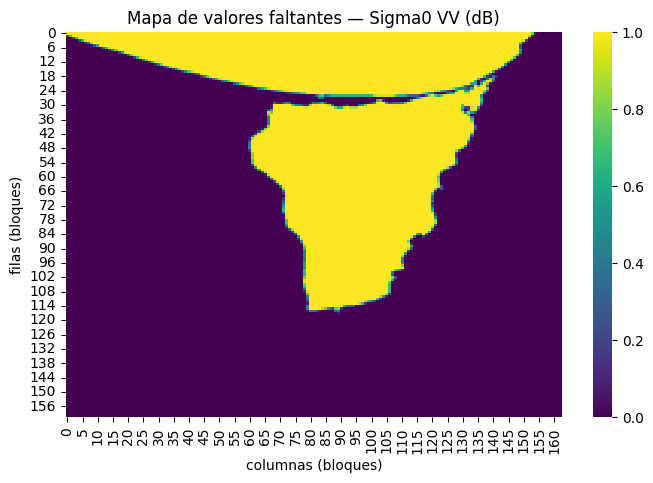

VH: faltantes = 7,555,487/27,880,094  (27.10%)


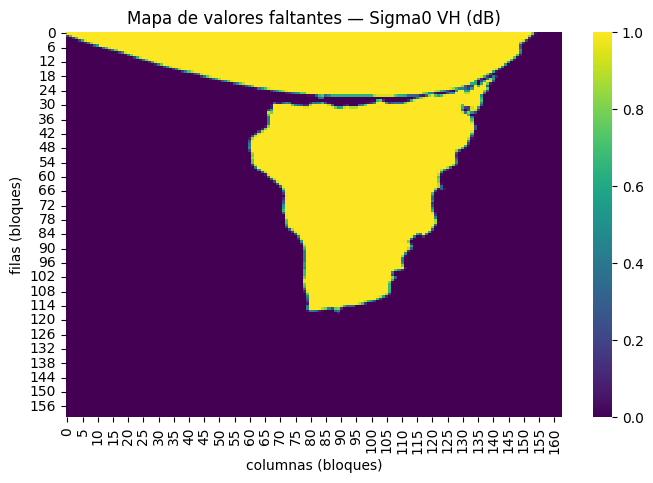

In [ ]:
#  BLOQUE AUTÓNOMO: carga VV/VH y hace heatmaps de faltantes
!pip -q install rasterio seaborn

import numpy as np, rasterio, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path

# Rutas
OUT = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs')
VV_PATH = OUT/'Sigma0_VV_CGSM_dB.tif'
VH_PATH = OUT/'Sigma0_VH_CGSM_dB.tif'  # opcional

def read_db(path: Path):
    with rasterio.open(path) as src:
        a = src.read(1, masked=True).astype('float32').filled(np.nan)
    # si viene en lineal (0–~1.5) -> convertir a dB donde >0
    if np.nanmin(a) >= 0 and np.nanpercentile(a, 95) <= 1.5:
        m = np.isfinite(a) & (a > 0)
        a[~m] = np.nan
        a[m] = 10*np.log10(a[m])
    return a

def missing_summary(arr):
    tot = arr.size
    miss = np.count_nonzero(~np.isfinite(arr))
    return miss, tot, 100*miss/tot

def block_missing(arr, target_blocks=160):
    H, W = arr.shape
    bh = max(1, H // target_blocks); bw = max(1, W // target_blocks)
    Hc = (H // bh) * bh; Wc = (W // bw) * bw
    A = arr[:Hc, :Wc]
    B = (~np.isfinite(A)).reshape(Hc//bh, bh, Wc//bw, bw)
    return B.mean(axis=(1,3))

def plot_miss_heat(name, arr):
    mg = block_missing(arr)
    plt.figure(figsize=(8,5))
    sns.heatmap(mg, vmin=0, vmax=1, cmap='viridis')
    plt.title(f"Mapa de valores faltantes — {name}")
    plt.xlabel("columnas (bloques)"); plt.ylabel("filas (bloques)")
    plt.show()

# VV
vv = read_db(VV_PATH)
m_vv, t_vv, p_vv = missing_summary(vv)
print(f"VV: faltantes = {m_vv:,}/{t_vv:,}  ({p_vv:.2f}%)")
plot_miss_heat("Sigma0 VV (dB)", vv)

# VH (si existe)
if VH_PATH.exists():
    vh = read_db(VH_PATH)
    m_vh, t_vh, p_vh = missing_summary(vh)
    print(f"VH: faltantes = {m_vh:,}/{t_vh:,}  ({p_vh:.2f}%)")
    plot_miss_heat("Sigma0 VH (dB)", vh)
else:
    print("VH no disponible.")



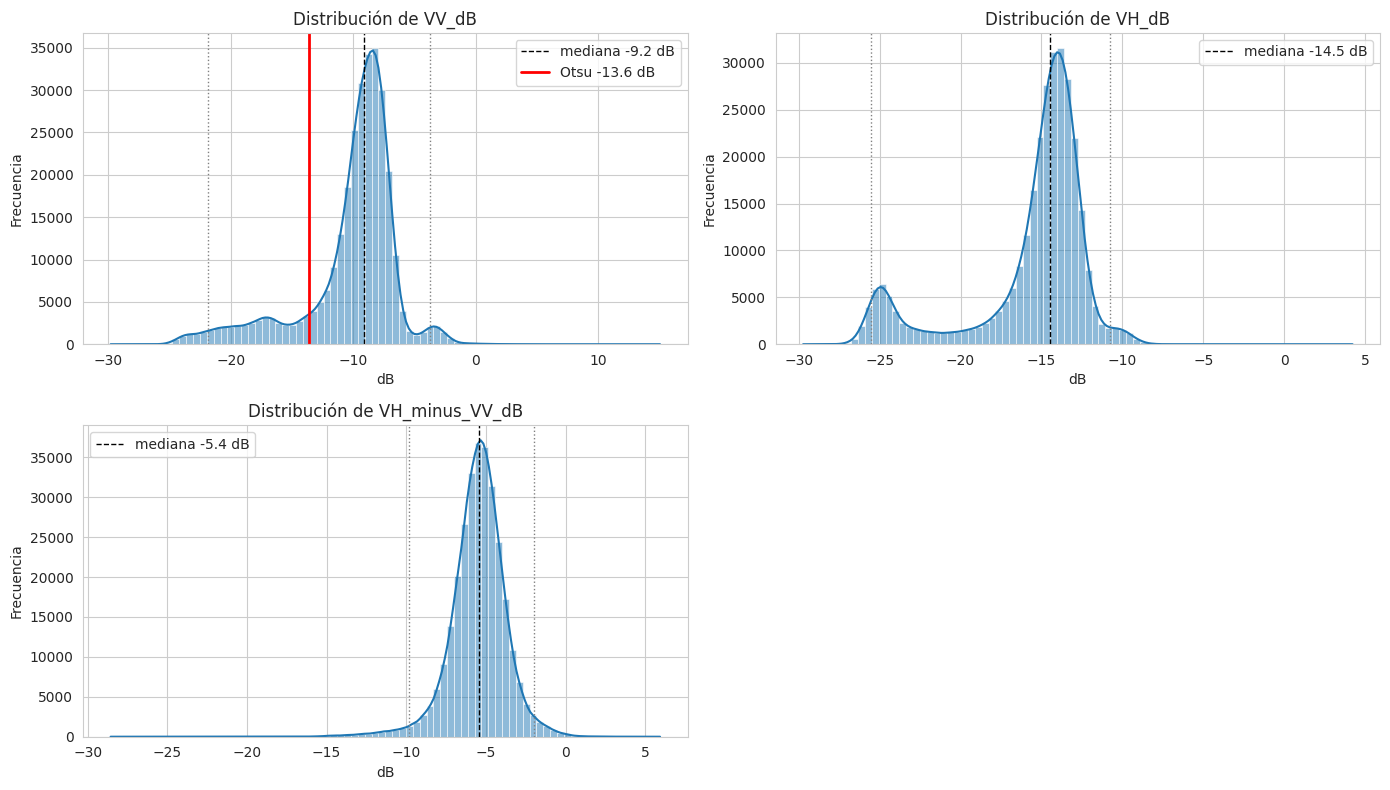

In [ ]:
# Histogramas multi-panel para VV/VH y derivados
!pip -q install rasterio seaborn scikit-image

from pathlib import Path
import numpy as np, matplotlib.pyplot as plt, seaborn as sns, rasterio
from skimage.filters import threshold_otsu

OUT = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs')
VV_PATH = OUT/'Sigma0_VV_CGSM_dB.tif'
VH_PATH = OUT/'Sigma0_VH_CGSM_dB.tif'  # si no existe, se omite

def read_db(path: Path):
    with rasterio.open(path) as src:
        a = src.read(1, masked=True).astype('float32').filled(np.nan)
    # si vino en lineal (0–~1.5) => convertir a dB donde >0
    if np.nanmin(a) >= 0 and np.nanpercentile(a,95) <= 1.5:
        m = np.isfinite(a) & (a > 0)
        a[~m] = np.nan; a[m] = 10*np.log10(a[m])
    return a

# Carga
vv = read_db(VV_PATH)
vh = read_db(VH_PATH) if VH_PATH.exists() else None

# Máscara válida y muestreo ligero para graficar
valid = np.isfinite(vv) & (np.isfinite(vh) if vh is not None else True)
rng = np.random.default_rng(0)
def ss(x, n=300_000):
    x = x[valid]
    if x.size > n: x = x[rng.choice(x.size, n, replace=False)]
    return x

# Variables a graficar
features = {"VV_dB": ss(vv)}
if vh is not None:
    features["VH_dB"] = ss(vh)
    features["VH_minus_VV_dB"] = ss(vh - vv)   # útil para resaltar vegetación

# Grid automático
sns.set_style("whitegrid")
cols = list(features.keys())
n = len(cols); ncols = 2; nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
axes = np.ravel(axes) if n > 1 else [axes]

for i, k in enumerate(cols):
    x = features[k]
    sns.histplot(x, bins=80, kde=True, ax=axes[i])
    p2, p50, p98 = np.nanpercentile(x, [2, 50, 98])
    axes[i].axvline(p2,  ls=":", color="gray", lw=1)
    axes[i].axvline(p50, ls="--", color="black", lw=1, label=f"mediana {p50:.1f} dB")
    axes[i].axvline(p98, ls=":", color="gray", lw=1)
    if k == "VV_dB":                       # umbral exploratorio de agua
        try:
            thr = float(threshold_otsu(x[np.isfinite(x)]))
            axes[i].axvline(thr, color="red", lw=2, label=f"Otsu {thr:.1f} dB")
        except Exception:
            pass
    axes[i].set_title(f"Distribución de {k}")
    axes[i].set_xlabel("dB"); axes[i].set_ylabel("Frecuencia")
    axes[i].legend()

# eliminar subplots vacíos si sobran
for j in range(i+1, len(axes)): fig.delaxes(axes[j])
plt.tight_layout(); plt.show()



## Análisis de gaussianidad de las distribuciones (VV, VH y VH−VV)

En radar SAR el speckle es ruido multiplicativo. Al transformar a dB (log), ese ruido se vuelve aditivo, por lo que los valores de una misma clase (p. ej., agua o vegetación) tienden a concentrarse alrededor de una media → comportamiento cuasi normal. Cuando en una escena hay varias clases, la distribución total es una mezcla de gaussianas.

**Resultados observados (CGSM):**
- VV (dB): mezcla con dos regímenes. Pico principal cerca de **–9.2 dB** (bordes/vegetación) y cola/segundo modo entre **–24 y –18 dB** (agua). El umbral Otsu ≈ –13.6 dB** cae en el valle entre modos → separación coherente *agua / no agua*.
- VH (dB): pico único más negativo (**mediana ≈ –14.5 dB**) con cola izquierda; refleja que VH devuelve menos energía y es más sensible a dispersión volumétrica en vegetación.
- VH − VV (dB): distribución estrecha y casi normal centrada en **≈ –5.4 dB**. Indica relación estable entre canales (VH ≈ VV − 5–6 dB) y menor mezcla de clases → rasgo muy útil.


**Conclusión.**
Las formas observadas son consistentes con la física del retroespalamiento y el tratamiento en dB: cada clase se comporta casi normal; la escena completa es su mezcla. Esto valida el umbral en VV.


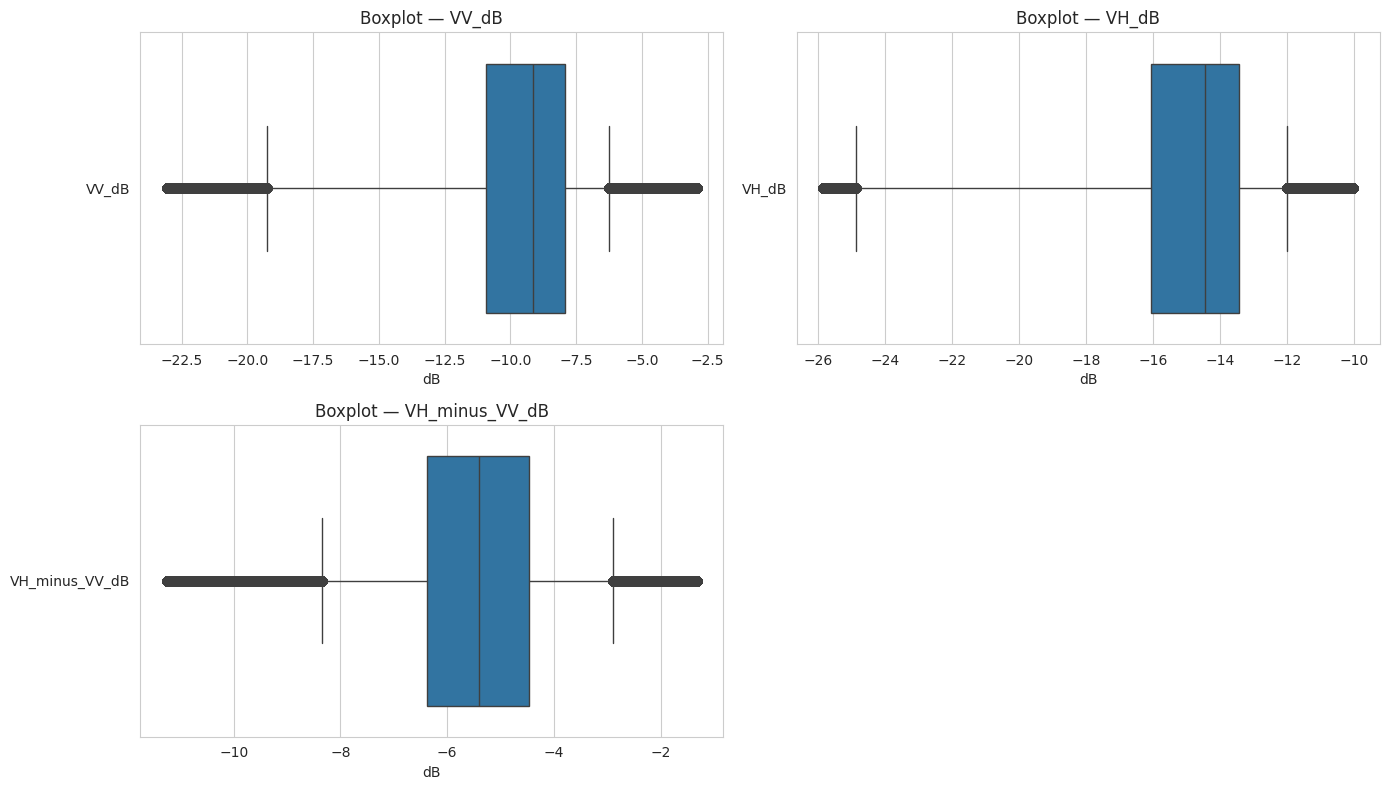

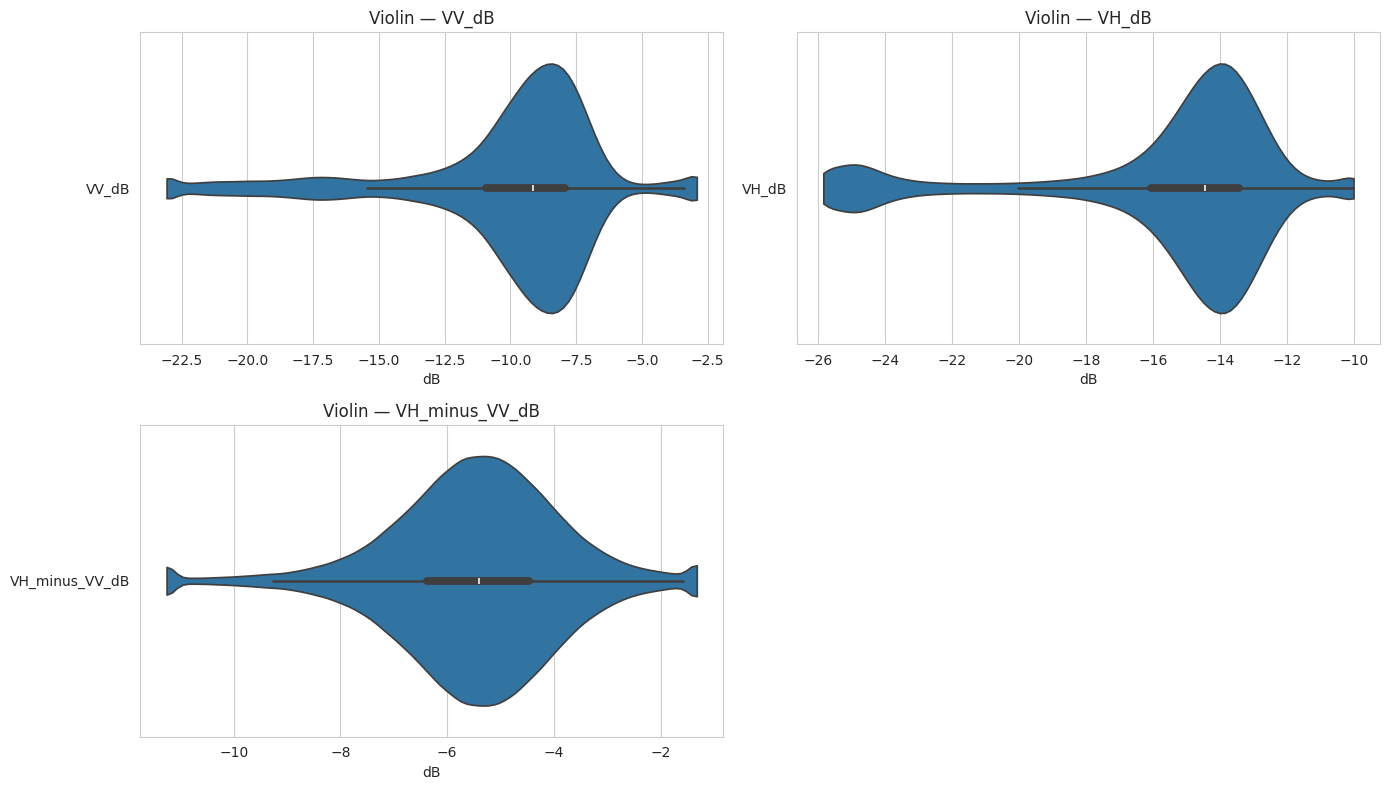

Resumen por variable (dB):


Variable               
VH_dB           n          250000.00
                p1            -25.85
                Q1            -16.07
                Mediana       -14.46
                Q3            -13.44
                p99           -10.01
                IQR             2.63
VH_minus_VV_dB  n          250000.00
                p1            -11.26
                Q1             -6.39
                Mediana        -5.41
                Q3             -4.46
                p99            -1.32
                IQR             1.92
VV_dB           n          250000.00
                p1            -23.07
                Q1            -10.93
                Mediana        -9.15
                Q3             -7.92
                p99            -2.91
                IQR             3.01
Name: dB, dtype: float64

In [ ]:
# Boxplots y Violin plots para VV/VH (SAR)
!pip -q install rasterio seaborn

from pathlib import Path
import numpy as np, pandas as pd, rasterio, seaborn as sns, matplotlib.pyplot as plt

OUT = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs')
VV_PATH = OUT/'Sigma0_VV_CGSM_dB.tif'
VH_PATH = OUT/'Sigma0_VH_CGSM_dB.tif'  # opcional

def read_db(path: Path):
    with rasterio.open(path) as src:
        a = src.read(1, masked=True).astype('float32').filled(np.nan)
    # si viene en lineal (0–~1.5) -> convertir a dB donde >0
    if np.nanmin(a) >= 0 and np.nanpercentile(a,95) <= 1.5:
        m = np.isfinite(a) & (a > 0)
        a[~m] = np.nan
        a[m]  = 10*np.log10(a[m])
    return a

# Carga
vv = read_db(VV_PATH)
vh = read_db(VH_PATH) if VH_PATH.exists() else None

# Muestra ligera y DataFrame en formato largo
valid = np.isfinite(vv) & (np.isfinite(vh) if vh is not None else True)
rng = np.random.default_rng(0)
idx = np.where(valid)
k = min(250_000, len(idx[0]))          # muestreo para gráficas
sel = rng.choice(len(idx[0]), k, replace=False)
rr, cc = idx[0][sel], idx[1][sel]

data = {"VV_dB": vv[rr,cc]}
if vh is not None:
    data["VH_dB"] = vh[rr,cc]
    data["VH_minus_VV_dB"] = vh[rr,cc] - vv[rr,cc]

df = (pd.DataFrame(data)
        .melt(var_name="Variable", value_name="dB")
        .dropna())

# (Opcional) recorte suave p1–p99 para evitar extremos que aplasten las figuras
def clip_by_quantiles(s):
    p1, p99 = np.nanpercentile(s, [1, 99])
    return s.clip(p1, p99)
df["dB"] = df.groupby("Variable")["dB"].transform(clip_by_quantiles)

# ----- Boxplots -----
sns.set_style("whitegrid")
nvars = df["Variable"].nunique()
ncols = 2
nrows = (nvars + ncols - 1)//ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
axes = np.ravel(axes) if nvars>1 else [axes]

for ax, var in zip(axes, df["Variable"].unique()):
    sns.boxplot(x="dB", y="Variable", data=df[df["Variable"]==var], ax=ax, whis=[5,95])
    ax.set_title(f"Boxplot — {var}")
    ax.set_xlabel("dB"); ax.set_ylabel("")
for j in range(len(df["Variable"].unique()), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout(); plt.show()

# ----- Violin plots -----
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows))
axes = np.ravel(axes) if nvars>1 else [axes]
for ax, var in zip(axes, df["Variable"].unique()):
    sns.violinplot(x="dB", y="Variable", data=df[df["Variable"]==var], ax=ax, inner="box", cut=0)
    ax.set_title(f"Violin — {var}")
    ax.set_xlabel("dB"); ax.set_ylabel("")
for j in range(len(df["Variable"].unique()), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout(); plt.show()

# ----- Resumen numérico rápido -----
def stats_ser(s):
    s = s.dropna()
    q = np.percentile(s, [25,50,75,1,99])
    return pd.Series({"n": len(s), "p1": q[3], "Q1": q[0], "Mediana": q[1], "Q3": q[2], "p99": q[4], "IQR": q[2]-q[0]})
print("Resumen por variable (dB):")
display(df.groupby("Variable")["dB"].apply(stats_ser).round(2))


## Análisis de histogramas (VV, VH y VH−VV)

**VV (dB)**  
- **Forma:** bimodal con asimetría a la izquierda.  
- **Mediana:** ≈ **−9.2 dB**.  
- **Modos:** uno muy negativo (**≈ −24 a −18 dB**, agua) y otro menos negativo (**≈ −12 a −6 dB**, bordes/vegetación).  
- **Umbral Otsu:** **≈ −13.6 dB**, cae en el valle entre modos → buen baseline para agua probable.  
- **Outliers:** valores muy negativos en bordes/sombras o agua muy lisa.

**VH (dB)**  
- **Forma:** pico único con cola izquierda.  
- **Mediana:** ≈ **−14.5 dB** (más negativo que VV).  
- **Interpretación:** VH (cross-pol) es más sensible a dispersión volumétrica en vegetación; el agua mantiene retornos muy bajos.

**VH − VV (dB)**  
- **Forma:** **estrecha y casi gaussiana**.  
- **Mediana:** ≈ **−5.4 dB**.  
- **Lectura:** relación estable entre canales (VH ≈ VV − 5–6 dB). Útil como **rasgo discriminante**: valores más positivos→ vegetación; cercanos a 0/negativos→ agua.

**Conclusión física**  
En SAR, el speckle multiplicativo al pasar a dB se vuelve aditivo, por lo que cada clase tiende a comportarse casi normal; la escena total es una mezcla de gaussianas (agua vs. vegetación/bordes). Los histogramas confirman esta separación y validan el uso de **VV ≤ −13.6 dB** como punto de partida para segmentación de agua.




Correlación Pearson:
                 VV_dB  VH_dB  VH_minus_VV_dB
VV_dB           1.000  0.893          -0.303
VH_dB           0.893  1.000           0.158
VH_minus_VV_dB -0.303  0.158           1.000

Correlación Spearman:
                 VV_dB  VH_dB  VH_minus_VV_dB
VV_dB           1.000  0.782          -0.367
VH_dB           0.782  1.000           0.169
VH_minus_VV_dB -0.367  0.169           1.000


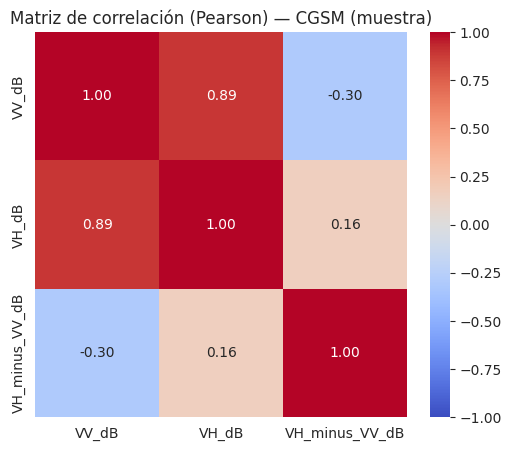

In [ ]:
# Correlación VV, VH y VH−VV
!pip -q install rasterio seaborn pandas

from pathlib import Path
import numpy as np, pandas as pd, rasterio, seaborn as sns, matplotlib.pyplot as plt

OUT = Path('/content/drive/MyDrive/DataScience_Sentinel1ProjectDegree/outputs')
VV_PATH = OUT/'Sigma0_VV_CGSM_dB.tif'
VH_PATH = OUT/'Sigma0_VH_CGSM_dB.tif'

def read_db(path: Path):
    with rasterio.open(path) as src:
        a = src.read(1, masked=True).astype('float32').filled(np.nan)
    # si vino en lineal (0–~1.5), convertir a dB donde >0
    if np.nanmin(a) >= 0 and np.nanpercentile(a,95) <= 1.5:
        m = np.isfinite(a) & (a > 0); a[~m] = np.nan; a[m] = 10*np.log10(a[m])
    return a

vv = read_db(VV_PATH)
vh = read_db(VH_PATH) if VH_PATH.exists() else None

valid = np.isfinite(vv) & (np.isfinite(vh) if vh is not None else True)
r, c = np.where(valid)
n = min(500_000, len(r))  # muestra para eficiencia
sel = np.random.default_rng(0).choice(len(r), n, replace=False)

vv_s = vv[r[sel], c[sel]]
data = {'VV_dB': vv_s}

if vh is not None:
    vh_s = vh[r[sel], c[sel]]
    data['VH_dB'] = vh_s
    data['VH_minus_VV_dB'] = vh_s - vv_s

df = pd.DataFrame(data).dropna()

# Matrices de correlación
corr_p = df.corr(method='pearson')
corr_s = df.corr(method='spearman')

print("Correlación Pearson:\n", corr_p.round(3))
print("\nCorrelación Spearman:\n", corr_s.round(3))

# Heatmap (Pearson)
plt.figure(figsize=(6,5))
sns.heatmap(corr_p, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Matriz de correlación (Pearson) — CGSM (muestra)')
plt.show()


## Análisis de la matriz de correlación (CGSM)

**Resultados (muestra):**
- **VV_dB vs VH_dB** → **alta correlación positiva** (Pearson ≈ **0.89**, Spearman ≈ **0.78**).  
   ambas bandas aumentan juntas cuando crece la rugosidad/vegetación (retroespalamiento más alto). Confirma que contienen señal **redundante**.
- **VV_dB vs (VH−VV)_dB** → **correlación negativa moderada** (≈ **−0.30** / **−0.37**).  
  *Razón física/matemática:* el diferencial incluye a VV con signo contrario; cuando VV sube, el término **VH−VV** tiende a bajar.
- **VH_dB vs (VH−VV)_dB** → **correlación débil positiva** (≈ **0.16**).  
  el diferencial conserva algo de la variación de VH pero añade información **menos redundante** que VV.

**Implicaciones:**
- **Colinealidad:** VV y VH están fuertemente correlacionadas.  

- **Física consistente:** la alta VV–VH refleja que ambas responden a la misma estructura superficial; el signo de las correlaciones con el diferencial coincide con su definición.


|

## Referencias

**Fuentes de datos**
- **Sentinel-1 GRD (IW, VV/VH)**. Agencia Espacial Europea (ESA). *Sentinel-1 User Guide / Level-1 Product*.  


  **Modelo digital de elevación usado para la corrección geométrica.**
**Software y flujos**
- **SNAP / S1TBX**. ESA (Science Toolbox Exploitation Platform). *Sentinel-1 Toolbox User Guide*.  
  Operadores usados: Apply-Orbit-File, Radiometric Calibration (sigma⁰), Speckle Filter, Range-Doppler Terrain Correction.

  **Métodos y artículos clave**
- Otsu, N. (1979). *A Threshold Selection Method from Gray-Level Histograms*. IEEE Trans. SMC, 9(1), 62–66.  
  (Umbral automático para separar agua/no-agua).
- Lee, J.-S. (1980). *Digital Image Enhancement and Noise Filtering by Use of Local Statistics*. IEEE TPAMI, 2(2), 165–168.  
  (Filtro de speckle tipo Lee).